Import

In [1]:
from classification.datasets import Dataset
from classification.utils.audio_student import Feature_vector_DS
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from classification.utils.utils import accuracy
import numpy as np
import os, threading
import matplotlib.pyplot as plt
from time import time

Initialisation

In [2]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()
### TO RUN
PATH = "data/feature_freq/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(PATH, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [3]:
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0, fs=10900)
train_pct = 0.7
featveclen = len(myds["fire", 0])  # number of items in a feature vector
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
nlearn = round(naudio * train_pct)  # number of sounds among naudio for training

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio * data_aug_factor)

"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X = np.zeros((data_aug_factor * nclass * naudio, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = myds[classname, idx]
            X[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
np.save(PATH + "feature_matrix_2D.npy", X)

class_ids_aug = np.repeat(classnames, naudio * data_aug_factor)
y = class_ids_aug.copy()

fonction pour thread

In [4]:
debut=500
fin=int(20e3)
pas=100
n_splits = 5
length = (fin-debut)//pas
t=0.0464

abscisse = np.zeros(length)
result = np.zeros(length)
std = np.zeros(length)


def fun(begin,end, step=pas, force=False, PCA_enable=False, NPCA=8):
    model_knn = RandomForestClassifier(150)
    print(step)
    pos_initial = (begin-debut)//step
    print(f"th : {begin}, {pos_initial}")

    t1 = time()
    if PCA_enable:
        pca = PCA(n_components=NPCA,whiten=True)
    for i in range(begin,end,step):
        #Creation/chargement des feature vector
        try:
            X = np.load(PATH+str(i)+"feature_matrix_2D.npy")
        except:
            myds_th = Feature_vector_DS(dataset, Nft=int(t*i), nmel=20, duration=5000, shift_pct=0.0,fs=i)
            featveclen=len(myds_th['fire', 0])
            X = np.zeros((data_aug_factor * nclass * naudio, featveclen))
            for s in range(data_aug_factor):
                for class_idx, classname in enumerate(classnames):
                    for idx in range(naudio):
                        featvec = myds_th[classname, idx]
                        X[s * nclass * naudio + class_idx * naudio + idx, :] = featvec
            np.save(PATH +str(i)+ "feature_matrix_2D.npy", X)
    
        #classification
        acc = []
        for _ in range(n_splits):
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)  # random_state=1

            mean = np.mean(X_train, axis=0)
            X_train_mean=X_train-mean
            X_learn_normalised = X_train_mean/ np.linalg.norm(X_train_mean, axis=1, keepdims=True)

            mean = np.mean(X_test, axis=0)
            X_val_mean=X_test-mean
            X_val_normalised = X_val_mean/ np.linalg.norm(X_val_mean, axis=1, keepdims=True)

            if PCA_enable:
                
                X_learn_normalised = pca.fit_transform(X_learn_normalised)
                X_val_normalised = pca.transform(X_val_normalised)

            if(len(X_learn_normalised[0])!=len(X_val_normalised[0])):
                raise(f"ERrOR {len(X_learn_normalised[0])}, {len(X_val_normalised[0])}")
            
            model_knn.fit(X_learn_normalised, y_train)
            prediction_knn = model_knn.predict(X_val_normalised)
            acc.append(accuracy(prediction_knn, y_test))


        k = pos_initial+(i-begin)//step
        result[k] = np.mean(acc)
        abscisse[k] = i
    t2=time()

    print(f"Fun\tfrom {begin} to {end} time ellapsed {t2-t1:.2f}")


Threading gogogo

thread lauchn between 250 and 5001
th : 250, 0
thread lauchn between 5000 and 10001
th : 5187, 19
thread lauchn between 10000 and 15001
th : 10124, 39
thread lauchn between 15000 and 19751
th : 15061, 59
Fun	from 15061 to 19998 time ellapsed 254.75
Fun	from 10124 to 15061 time ellapsed 256.07
Fun	from 5187 to 10124 time ellapsed 257.72
Fun	from 250 to 5187 time ellapsed 258.31


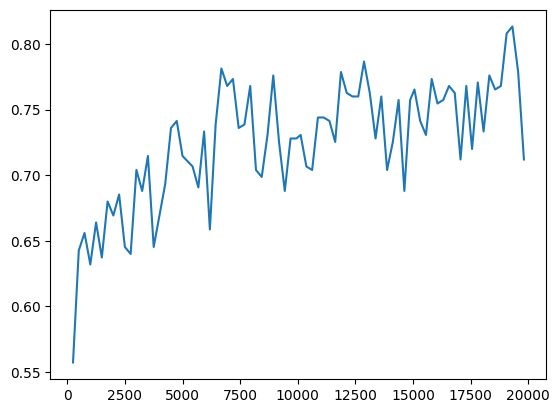

In [16]:
number_of_thread = 4
threads = []

space = (fin-debut)//number_of_thread
commencement=debut
for i in range(number_of_thread):
    print(f"thread lauchn between {commencement+i*space-(commencement+i*space)%pas} and {commencement+(i+1)*space-(commencement+(i+1)*space)%pas+1}")
    thread = threading.Thread(target=fun, args=(commencement+i*space, commencement+(i+1)*space,pas))
    thread.start()
    threads.append(thread)

# Attendre que tous les threads se terminent
for thread in threads:
    thread.join()

#Plot
    
plt.plot(abscisse,result)
plt.show()


thread lauchn between 500 and 4401
100
th : 500, 0
thread lauchn between 4400 and 8301
100
th : 4400, 39
thread lauchn between 8300 and 12201
100
th : 8300, 78
thread lauchn between 12200 and 16101
100
th : 12200, 117
thread lauchn between 16100 and 20001
100
th : 16100, 156
Fun	from 12200 to 16101 time ellapsed 285.08


Exception in thread Thread-13 (fun):
Traceback (most recent call last):
  File "C:\Users\barra\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\barra\Desktop\Projetelec\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 761, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\barra\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\barra\AppData\Local\Temp\ipykernel_6652\990066327.py", line 65, in fun
IndexError: index 195 is out of bounds for axis 0 with size 195


Fun	from 4400 to 8301 time ellapsed 285.91
Fun	from 8300 to 12201 time ellapsed 286.34
Fun	from 500 to 4401 time ellapsed 287.06


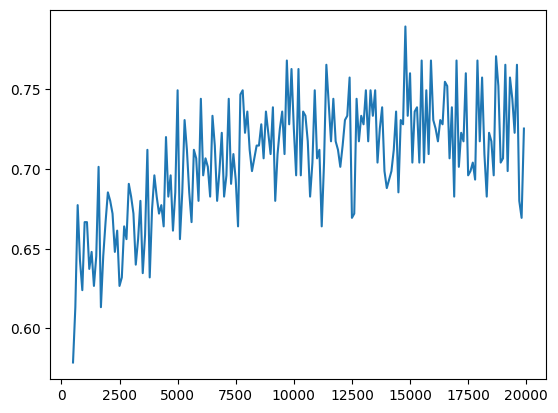

In [6]:
number_of_thread = 5
threads = []

space = (fin-debut)//number_of_thread
commencement=debut
for i in range(number_of_thread):
    print(f"thread lauchn between {commencement+i*space-(commencement+i*space)%pas} and {commencement+(i+1)*space-(commencement+(i+1)*space)%pas+1}")
    thread = threading.Thread(target=fun, args=(commencement+i*space-(commencement+i*space)%pas, commencement+(i+1)*space-(commencement+(i+1)*space)%pas+1,pas, False,True))
    thread.start()
    threads.append(thread)

# Attendre que tous les threads se terminent
for thread in threads:
    thread.join()

#Plot
    
plt.plot(abscisse,result)
plt.show()

In [22]:
couleur=["green","purple","yellow","orange"]
for i in range(5000,1000,1000):

    lim = np.where(abscisse==i)[0][0]
    p,m = np.polyfit(abscisse[:lim],result[:lim],1)
    p1,m1 = np.polyfit(abscisse[lim:],result[lim:],1)
    print(p1)
    plt.plot(abscisse,result)
    plt.plot(abscisse[:lim],p*abscisse[:lim]+m,color=couleur[(i-5000)//1000])
    plt.plot(abscisse[lim:],p1*abscisse[lim:]+m1,color=couleur[(i-5000)//1000])
    plt.show()

